# P2. Les vues SQL

## Définition d'une vue SQL  

Une vue n'est rien de plus qu'une instruction SQLite qui est stockée dans la base de données avec un nom associé. Il s'agit en fait d'une composition d'une table sous la forme d'une requête SQLite prédéfinie.

Une vue peut contenir toutes les lignes d'une table ou des lignes sélectionnées d'une ou plusieurs tables. Une vue peut être créée à partir d'une ou plusieurs tables qui dépendent de la requête SQLite écrite pour créer une vue.

## Code utilitaire

In [1]:
import os
import sqlite3
import pandas as pd   

In [2]:
from pathlib import Path

In [3]:
# Ouvre connection vers SQLite db
chemin_bdd = Path('db') / 'chinook.db'
conn = sqlite3.connect(chemin_bdd)

In [4]:
# Fonction permettant d'exécuter un requête SQL sur une BDD définie par sa connexion conn
def executer_requete(requete_sql, conn):
    try:
        cursor = conn.cursor()
        cursor.execute(requete_sql)
        conn.commit()
    except sqlite3.Error as e:
        print("Erreur lors de l'execution de la requête")
        print(e)
        return
    cursor.close()


## Example de vue SQL: v_albums

La requête suivante permet d'obtenir une liste (simplifiée) des albums / artistes correspondants:  

In [5]:
# Requete sur les tables albums & artists
requete = """
    SELECT AlbumId,
           Title,
           a.Name AS Artist
    FROM albums
    JOIN artists a on albums.ArtistId = a.ArtistId
    ORDER BY Artist;
"""

albums = pd.read_sql_query(requete, conn)
albums.head(5)

,AlbumId,Title,Artist
0,1,For Those About To Rock We Salute You,AC/DC
1,4,Let There Be Rock,AC/DC
2,296,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra
3,267,Worlds,Aaron Goldberg
4,280,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...


Le code ci-dessous permet de créer une vue correspondant à la requête ci-dessous :    
Référence vue sous SQLite : https://www.sqlite.org/lang_createview.html

In [6]:
# creation vue albums avec artistes
creation_vue_albums = """
    CREATE VIEW v_albums (
        AlbumId,
        Title,
        Artist)
    AS
        SELECT AlbumId,
               Title,
               a.Name AS Artist
        FROM albums
        JOIN artists a on albums.ArtistId = a.ArtistId
        ORDER BY Artist, Title;
"""

executer_requete(creation_vue_albums, conn)

Erreur lors de l'execution de la requête
table v_albums already exists


Une fois la vue créé, on peut la réutiliser dans des requêtes SQL comme une table:  

In [7]:
# Utilisation de la vue v_albums
albums = pd.read_sql_query("SELECT * FROM v_albums LIMIT 10;", conn)
albums.head(5)

,AlbumId,Title,Artist,Nb_tracks,Duration,Price
0,1,For Those About To Rock We Salute You,AC/DC,10,35,9.90
1,4,Let There Be Rock,AC/DC,8,38,7.92
2,296,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra,1,3,0.99
3,267,Worlds,Aaron Goldberg,1,4,0.99
4,280,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...,2,7,1.98


In [8]:
# Utilisation de la vue v_albums avec une clause WHERE
albums = pd.read_sql_query("SELECT * FROM v_albums WHERE Artist = 'U2';", conn)
albums

,AlbumId,Title,Artist,Nb_tracks,Duration,Price
0,232,Achtung Baby,U2,12,49,11.88
1,233,All That You Can't Leave Behind,U2,11,43,10.89
2,234,B-Sides 1980-1990,U2,15,51,14.85
3,235,How To Dismantle An Atomic Bomb,U2,11,43,10.89
4,255,Instant Karma: The Amnesty International Campa...,U2,23,73,22.77
5,236,Pop,U2,12,54,11.88
6,237,Rattle And Hum,U2,17,64,16.83
7,238,The Best Of 1980-1990,U2,14,56,13.86
8,239,War,U2,10,37,9.90
9,240,Zooropa,U2,10,45,9.90


In [9]:
# Utilisation de la vue v_albums avec une autre jointure
requete = """
    SELECT a.AlbumId,
           a.Title,
           a.Artist,
           count(t.TrackId) as Tracks
    FROM v_albums a
    JOIN tracks t ON a.AlbumId = t.AlbumId
    GROUP BY 1, 2, 3
    ORDER BY 3, 2;
"""
albums = pd.read_sql_query(requete, conn)
albums.head()

,AlbumId,Title,Artist,Tracks
0,1,For Those About To Rock We Salute You,AC/DC,10
1,4,Let There Be Rock,AC/DC,8
2,296,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra,1
3,267,Worlds,Aaron Goldberg,1
4,280,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...,2


In [10]:
# Effacer une vue
executer_requete("DROP VIEW IF EXISTS v_albums;", conn)

### Question: Avantages & Inconvénients des vues SQL

Quelles sont les avantages et inconvénients des vues SQL ?  

Avantages : 
- Simplifie la complexité des requêtes
- Evite les répétitions
- Permet les colonnes calculées
- Permet de gérer/fournir les accès de certaines données avec des permissions

Inconvénients : 
- Lors de la modification de la structure dd'une table, la vue doit être modifiée également
- Ralentit les performances d'une requête

---

## Exercices de création / mise en oeuvre de vues

### Vue 1: caractéristiques complètes des Albums  
A partir de l'exemple de vue ci-dessus, créer et exploiter une nouvelle vue v_albums reprenant pour chaque album:  
- AlbumId
- Title
- Artist
- nb de pistes
- Durée totale de l'album (en minutes)
- Prix de l'album

In [11]:
creation_vue_albums = """
    CREATE VIEW v_albums (
        AlbumId,
        Title,
        Artist,
        Nb_tracks,
        Duration,
        Price)
    AS
        SELECT a.AlbumId,
               a.Title,
               a2.Name AS Artist,
               COUNT(t.TrackId) as Nb_tracks,
               SUM(Milliseconds/(1000*60)) as Duration,
               SUM(UnitPrice) as Price
               
        FROM albums a
        INNER JOIN artists a2 ON a.ArtistId = a2.ArtistId
        INNER JOIN tracks t ON a.AlbumId = t.AlbumId
        GROUP BY a.AlbumId
        ORDER BY Artist, Title;
"""

executer_requete(creation_vue_albums, conn)

In [12]:
# Utilisation de la vue v_albums
albums = pd.read_sql_query("SELECT * FROM v_albums LIMIT 10;", conn)
albums.head(5)

,AlbumId,Title,Artist,Nb_tracks,Duration,Price
0,1,For Those About To Rock We Salute You,AC/DC,10,35,9.90
1,4,Let There Be Rock,AC/DC,8,38,7.92
2,296,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra,1,3,0.99
3,267,Worlds,Aaron Goldberg,1,4,0.99
4,280,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...,2,7,1.98


### Vue 2: caractéristiques détaillées des pistes
Créer et exploiter une nouvelle vue v_tracks reprenant pour chaque piste:  
- TrackId
- Name
- Genre
- Album
- Artist
- Composer
- Temps (en seconde)
- MediaType

In [13]:
creation_vue_tracks = """
    CREATE VIEW v_tracks (
        TrackId,
        Name,
        Genre,
        Album,
        Artist,
        Composer,
        Duration,
        MediaType)
    AS
        SELECT t.TrackId AS TrackId,
               t.Name AS Name,
               g.Name AS Genre,
               a.Title AS Album,
               a2.Name AS Artist,
               t.Composer AS Composer,
               t.Milliseconds/1000 AS Duration,
               mt.Name AS MediaType
        FROM tracks t 
        INNER JOIN albums a ON t.AlbumId = a.AlbumId 
        INNER JOIN artists a2 ON a.ArtistId = a2.ArtistId 
        INNER JOIN genres g ON t.GenreId = g.GenreId 
        INNER JOIN media_types mt ON t.MediaTypeId = mt.MediaTypeId 
        ORDER BY t.Name, a.Title 
"""

executer_requete(creation_vue_tracks, conn)

Erreur lors de l'execution de la requête
table v_tracks already exists


In [14]:
# Utilisation de la vue v_tracks
tracks = pd.read_sql_query("SELECT * FROM v_tracks LIMIT 10;", conn)
tracks.head(5)

,TrackId,Name,Genre,Album,Artist,Composer,Duration,MediaType
0,3027,"""40""",Rock,War,U2,U2,157,MPEG audio file
1,2918,"""?""",TV Shows,"Lost, Season 2",Lost,None,2782,Protected MPEG-4 video file
2,3412,"""Eine Kleine Nachtmusik"" Serenade In G, K. 525...",Classical,Sir Neville Marriner: A Celebration,Academy of St. Martin in the Fields Chamber En...,Wolfgang Amadeus Mozart,348,Protected AAC audio file
3,109,#1 Zero,Alternative & Punk,Out Of Exile,Audioslave,"Cornell, Commerford, Morello, Wilk",299,MPEG audio file
4,3254,#9 Dream,Pop,Instant Karma: The Amnesty International Campa...,U2,None,278,Protected AAC audio file


### Vue 3: Vue augmentée invoices
A. Créer une nouvelle vue v_invoices à partir de la table invoices ajoutant 3 nouveaux attributs basés sur l'attribut `InvoiceDate`:  
- semaine de la transaction
- mois de la transaction
- année de la transaction

In [15]:
executer_requete("DROP VIEW IF EXISTS v_invoices;", conn)

In [16]:
creation_vue_invoices = """
CREATE VIEW v_invoices (
        InvoiceId,
        InvoiceYear,
        InvoiceMonth, 
        InvoiceWeek,
        CustomerId,
        BillingAddress,
        BillingCity,
        BillingState,
        BillingCountry,
        BillingPostalCode,
        Total)
    AS
        SELECT i.InvoiceId, 
        (SELECT STRFTIME('%Y', i.InvoiceDate)) AS InvoiceYear, 
		(SELECT STRFTIME('%m', i.InvoiceDate)) AS InvoiceMonth, 
        (SELECT STRFTIME('%W', i.InvoiceDate)) AS InvoiceWeek,
        i.CustomerId, i.BillingAddress, i.BillingCity, i.BillingState, i.BillingCountry, i.BillingPostalCode, i.Total
        FROM invoices i

"""

executer_requete(creation_vue_invoices, conn)

In [17]:
# Utilisation de la vue v_tracks
tracks = pd.read_sql_query("SELECT * FROM v_invoices WHERE InvoiceMonth = '01' LIMIT 10;", conn)
tracks.head(5)

,InvoiceId,InvoiceYear,InvoiceMonth,InvoiceWeek,CustomerId,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2009,01,00,2,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,2009,01,00,4,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,2009,01,00,8,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,2009,01,01,14,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,2009,01,01,23,69 Salem Street,Boston,MA,USA,2113,13.86


B. Exploiter la vue v_invoices ainsi crée pour déterminer les ventes annuelles par pays.

In [18]:
requete = pd.read_sql_query("""SELECT BillingCountry, InvoiceYear,
SUM(v.Total) AS Total
FROM v_invoices v
GROUP BY InvoiceYear, BillingCountry
ORDER BY BillingCountry, InvoiceYear ASC""", conn)
requete

,BillingCountry,InvoiceYear,Total
0,Argentina,2010,11.88
1,Argentina,2011,0.99
2,Argentina,2013,24.75
3,Australia,2009,11.88
4,Australia,2010,0.99
...,...,...,...
96,United Kingdom,2009,25.74
97,United Kingdom,2010,30.69
98,United Kingdom,2011,17.82
99,United Kingdom,2012,9.90


In [19]:
top_vente_pays = pd.read_sql_query("""SELECT BillingCountry, InvoiceYear,
SUM(v.Total) AS Total
FROM v_invoices v
WHERE BillingCountry = "France" OR BillingCountry = "USA" OR BillingCountry = "United Kingdom"
GROUP BY InvoiceYear, BillingCountry
ORDER BY Total DESC
""", conn)


In [20]:
top_vente_pays

,BillingCountry,InvoiceYear,Total
0,USA,2012,127.98
1,USA,2009,103.95
2,USA,2011,103.01
3,USA,2010,102.98
4,USA,2013,85.14
5,France,2011,42.61
6,France,2013,40.59
7,France,2010,39.60
8,France,2012,36.66
9,France,2009,35.64


### Vue 4: A vous de jouer
Créer et exploiter une nouvelle vue de votre choix  

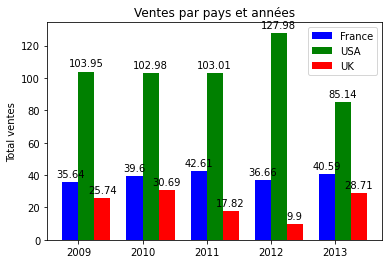

In [21]:
from matplotlib import pyplot as plt
import numpy as np

FR = top_vente_pays.loc[top_vente_pays.BillingCountry == "France"].sort_values(by=['InvoiceYear'])

years = FR.InvoiceYear

FR = FR.Total

US = top_vente_pays.loc[top_vente_pays.BillingCountry == "USA"].sort_values(by=['InvoiceYear'])
US = US.Total

UK = top_vente_pays.loc[top_vente_pays.BillingCountry == "United Kingdom"].sort_values(by=['InvoiceYear'])
UK = UK.Total

X = np.arange(len(years))
fig, ax = plt.subplots()

bars1 = ax.bar(X - 0.25/2, FR, color = 'b', width = 0.25, label="France")
bars2 = ax.bar(X + 0.25/2, US, color = 'g', width = 0.25, label="USA")
bars3 = ax.bar(X + 0.75/2, UK, color = 'r', width = 0.25, label="UK")

ax.set_ylabel('Total ventes')
ax.set_title('Ventes par pays et années')
ax.set_xticks(X)
ax.set_xticklabels(years)
ax.legend()

def autolabel(bars):
    """Ajoute un label pour chaque bar"""
    for bar in bars:
        height = round(bar.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

